![logo](https://www.databolt.tech/images/logo.png)
Accelerate data science [www.databolt.tech](https://www.databolt.tech) | [github.com/d6t/d6t-python](https://github.com/d6t/d6t-python)


# DATA SCIENCE PROJECT TEMPLATES

## Regression
### UCI heart disease data

In [3]:
# processing
import d6tflow, luigi, d6tpipe
import pandas as pd
import numpy as np
import pathlib

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate
import lightgbm
#lightgbm.LGBMRegressor
import shap
#shap.initjs()

# project
# import cfg, tasks
# import importlib # optional
# importlib.reload(cfg)
# importlib.reload(tasks)
# importlib.reload(visualize)


## preprocessing

In [4]:
import d6tflow.pipes

d6tflow.pipes.init('intro-stat-learning',profile='default', reset=True) #, local_pipe=True
pipe = d6tflow.pipes.get_pipe()
pipe.pull()

Connected to https://pipe.databolt.tech as citynorman
Successfully connected to pipe intro-stat-learning.  Read only access
pulling: 0.00MB


0it [00:00, ?it/s]


[]

In [5]:
print('where files are stored:',pipe.dirpath)

where files are stored: d:\d6tpipe-files\files\default\intro-stat-learning


In [35]:
# tasks

class TaskProcessRawData(d6tflow.tasks.TaskPqPandas):

    def run(self):        
        pipe=d6tpipe.PipeLocal('intro-stat-learning')
        df = pd.read_csv(pipe.dirpath/'Heart.csv',index_col=0)
        self.save(df)

@d6tflow.requires(TaskProcessRawData)
class TaskFeatures(d6tflow.tasks.TaskPqPandas):
    factorize = luigi.BoolParameter(default=True)
    
    def run(self):
        df = self.inputLoad()
        if self.factorize:
            for col in ['ChestPain','Thal']:
                df[col]=df[col].factorize()[0]
            df['AHD']=df['AHD'].map({'No':0,'Yes':1})
        df['target']=df['AHD']
        df = df.dropna()
        self.save(df)

In [36]:
d6tflow.run([TaskFeatures()],forced_all=True,confirm=False)
df_train = TaskFeatures().outputLoad()

INFO: Informed scheduler that task   TaskFeatures_True_e0eded0c4b   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   TaskFeatures_True_e0eded0c4b   has status   PENDING
INFO: Informed scheduler that task   TaskProcessRawData__99914b932b   has status   DONE
INFO:luigi-interface:Informed scheduler that task   TaskProcessRawData__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO:luigi-interface:Done scheduling tasks
INFO: Running Worker with 1 processes
INFO:luigi-interface:Running Worker with 1 processes
INFO: [pid 19452] Worker Worker(salt=310085983, workers=1, host=DESKTOP-4OCFNJU, username=deepmind, pid=19452) running   TaskFeatures(factorize=True)
INFO:luigi-interface:[pid 19452] Worker Worker(salt=310085983, workers=1, host=DESKTOP-4OCFNJU, username=deepmind, pid=19452) running   TaskFeatures(factorize=True)
INFO: [pid 19452] Worker Worker(salt=310085983, workers=1, host=DESKTOP-4OCFNJU, username=deepmind, pid=19452) done      TaskFeatures(facto

In [37]:
df_train = TaskFeatures().outputLoad()

In [32]:
cfg_col_X_cat = ['Sex', 'Fbs', 'ExAng', 'RestECG', 'Slope', 'ChestPain', 'Thal', 'Ca']
cfg_col_X_num = ['Oldpeak', 'Age', 'RestBP', 'MaxHR', 'Chol']
cfg_col_X = cfg_col_X_cat+cfg_col_X_num
cfg_col_Y = 'target'

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

## data overview

In [22]:
print(df_train.columns)

Index(['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
       'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'AHD', 'target'],
      dtype='object')


In [23]:
df_train.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD,target
1,63,1,0,145,233,1,2,150,0,2.3,3,0.0,0,0,0
2,67,1,1,160,286,0,2,108,1,1.5,2,3.0,1,1,1
3,67,1,1,120,229,0,2,129,1,2.6,2,2.0,2,1,1
4,37,1,2,130,250,0,0,187,0,3.5,3,0.0,1,0,0
5,41,0,3,130,204,0,2,172,0,1.4,1,0.0,1,0,0


In [24]:
print('observations and type')
df_train.info()

observations and type
<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1 to 303
Data columns (total 15 columns):
Age          303 non-null int64
Sex          303 non-null int64
ChestPain    303 non-null int64
RestBP       303 non-null int64
Chol         303 non-null int64
Fbs          303 non-null int64
RestECG      303 non-null int64
MaxHR        303 non-null int64
ExAng        303 non-null int64
Oldpeak      303 non-null float64
Slope        303 non-null int64
Ca           299 non-null float64
Thal         303 non-null int64
AHD          303 non-null int64
target       303 non-null int64
dtypes: float64(2), int64(13)
memory usage: 37.9 KB


In [25]:
print('missing values')
df_train.apply(lambda x: x.isna().sum()/len(x))

missing values


Age          0.000000
Sex          0.000000
ChestPain    0.000000
RestBP       0.000000
Chol         0.000000
Fbs          0.000000
RestECG      0.000000
MaxHR        0.000000
ExAng        0.000000
Oldpeak      0.000000
Slope        0.000000
Ca           0.013201
Thal         0.000000
AHD          0.000000
target       0.000000
dtype: float64

In [28]:
print('unique values')
df_train.apply(lambda x: len(x.unique()))

unique values


Age           41
Sex            2
ChestPain      4
RestBP        50
Chol         152
Fbs            2
RestECG        3
MaxHR         91
ExAng          2
Oldpeak       40
Slope          3
Ca             5
Thal           4
AHD            2
target         2
dtype: int64

In [26]:
df_train.describe().round(2)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD,target
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,299.00,303.00,303.00,303.00
mean,54.44,0.68,1.54,131.69,246.69,0.15,0.99,149.61,0.33,1.04,1.60,0.67,1.31,0.46,0.46
std,9.04,0.47,0.86,17.60,51.78,0.36,0.99,22.88,0.47,1.16,0.62,0.94,0.61,0.50,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,-1.00,0.00,0.00
25%,48.00,0.00,1.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,1.00,0.00,0.00
50%,56.00,1.00,1.00,130.00,241.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00,1.00,0.00,0.00
75%,61.00,1.00,2.00,140.00,275.00,0.00,2.00,166.00,1.00,1.60,2.00,1.00,2.00,1.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,2.00,1.00,1.00


### distribution of target variable

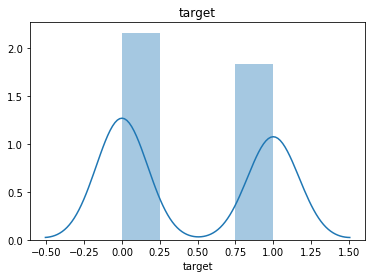

In [33]:
sns.distplot(df_train[cfg_col_Y]).set_title(cfg_col_Y);

### distribution of input variables

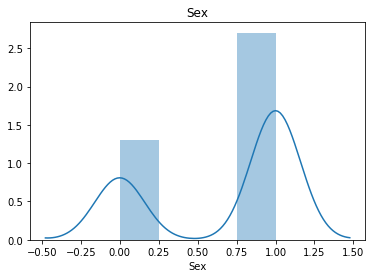

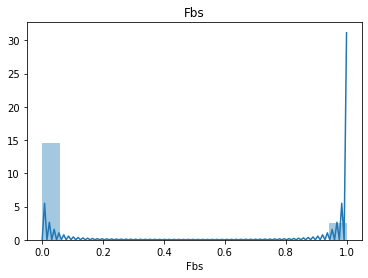

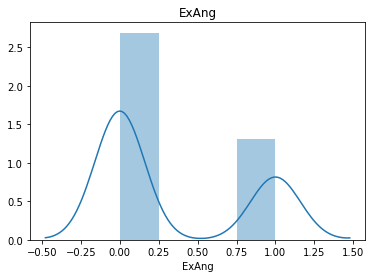

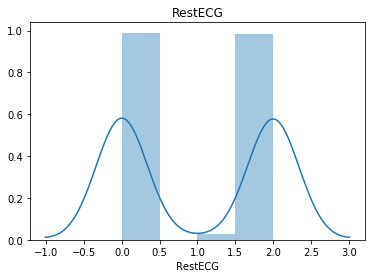

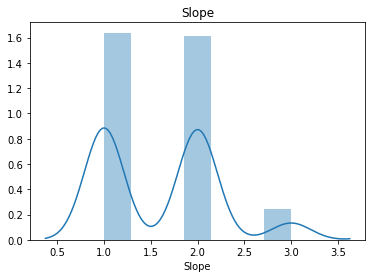

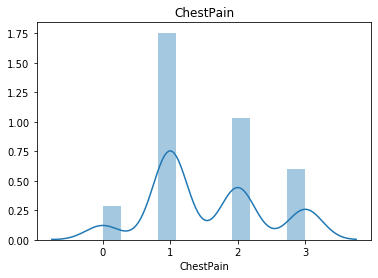

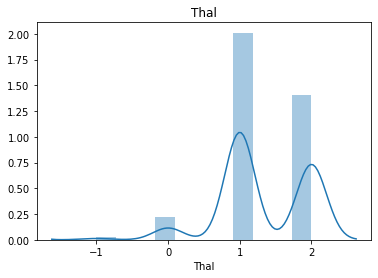

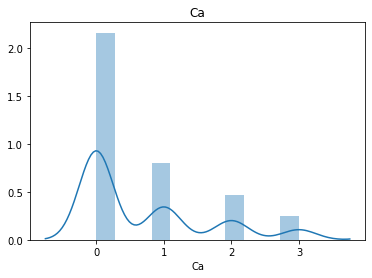

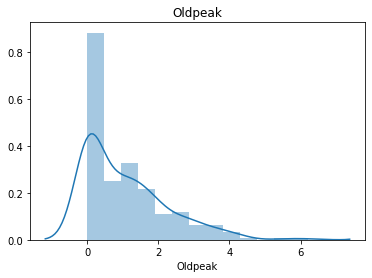

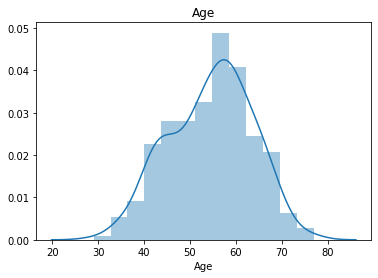

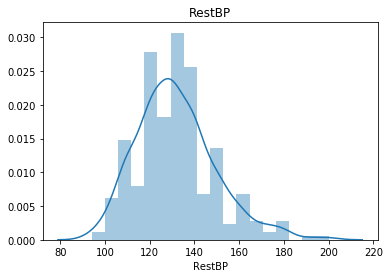

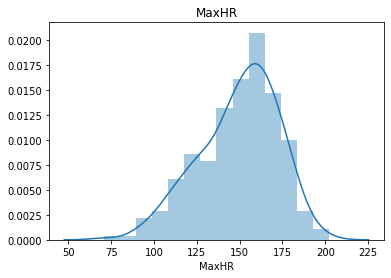

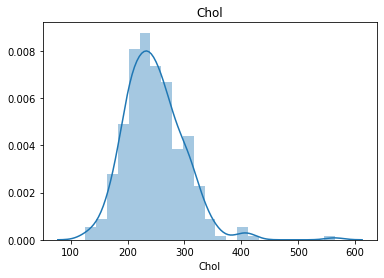

In [38]:
for icol in cfg_col_X:
    plt.figure();
    sns.distplot(df_train[icol]).set_title(icol);


### relation of inut variables to target variable

<Figure size 432x288 with 0 Axes>

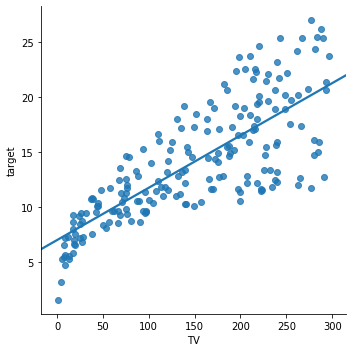

<Figure size 432x288 with 0 Axes>

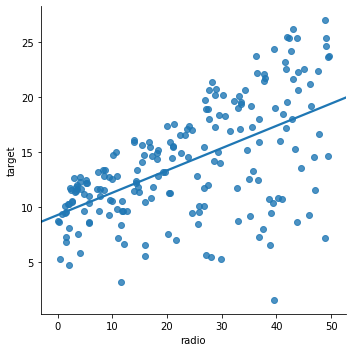

<Figure size 432x288 with 0 Axes>

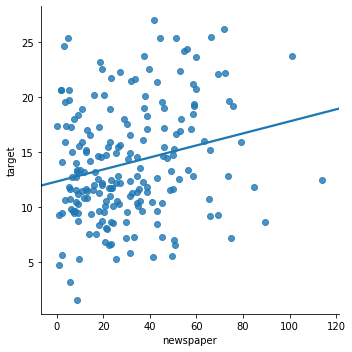

In [16]:
for icol in cfg_col_X_num:
    plt.figure();
    sns.lmplot(x=icol, y=cfg_col_Y, data=df_train, ci=None);

In [ ]:
for icol in cfg_col_cat:
    print(icol)
    print(df_heart.groupby(icol)['target'].agg(['mean','count']))


## model training

In [17]:
df_trainX, df_trainY = df_train[cfg_col_X], df_train[cfg_col_Y]

In [18]:
df_train['target_naive1']=df_train['target'].mean()

In [19]:
mod_ols = sm.OLS(df_trainY,sm.add_constant(df_trainX))

res_ols = mod_ols.fit()
print(res_ols.summary())
df_train['target_ols']=res_ols.predict()

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.58e-96
Time:                        10:50:47   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

In [20]:
from sklearn.linear_model import LinearRegression

mod_skols = LinearRegression()
mod_skols.fit(df_trainX,df_trainY)
df_train['target_skols']=mod_skols.predict(df_trainX)

In [21]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm.fit(df_trainX,df_trainY)
df_train['target_lgbm']=mod_lgbm.predict(df_trainX)

## model evaluation

### prediction errors: in-sample

In [22]:
print('naive mean',mean_squared_error(df_train[cfg_col_Y],df_train['target_naive1']))
print('ols',mean_squared_error(df_train[cfg_col_Y],df_train['target_skols']))
print('gbm',mean_squared_error(df_train[cfg_col_Y],df_train['target_lgbm']))

naive mean 27.085743750000002
ols 2.784126314510936
gbm 0.4284192451295194


### prediction errors: cross-validation

In [23]:
print('ols',-cross_validate(mod_skols, df_trainX, df_trainY, return_train_score=False, scoring=('r2', 'neg_mean_squared_error'), cv=10)['test_neg_mean_squared_error'].mean())
print('gbm',-cross_validate(mod_lgbm, df_trainX, df_trainY, return_train_score=False, scoring=('r2', 'neg_mean_squared_error'), cv=10)['test_neg_mean_squared_error'].mean())

ols 3.059967618118513
gbm 1.0701552068792164


## model interpretation

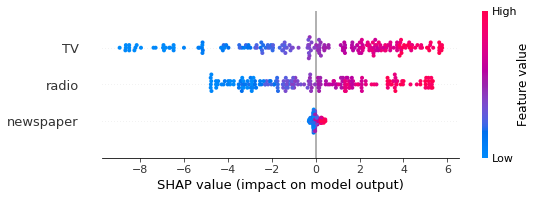

In [24]:
explainer = shap.TreeExplainer(mod_lgbm, df_trainX)
shap_values = explainer.shap_values(df_trainX)

shap.summary_plot(shap_values, df_trainX)


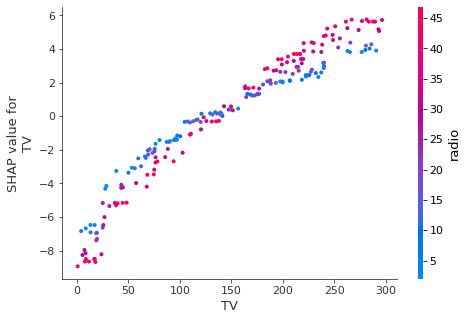

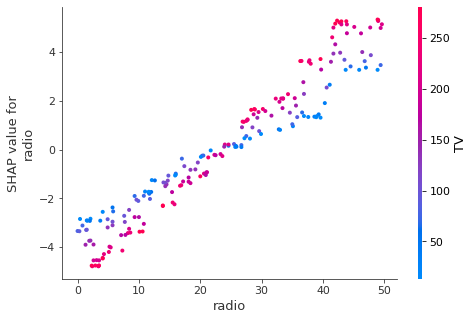

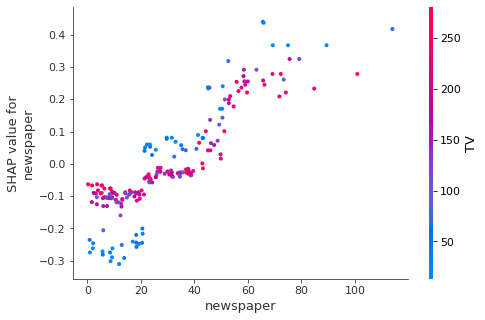

In [25]:
for col in cfg_col_X:
    shap.dependence_plot(col, shap_values, df_trainX)#,interaction_index=None)

In [26]:
dict(zip(cfg_col_X,range(len(cfg_col_X))))

{'TV': 0, 'radio': 1, 'newspaper': 2}

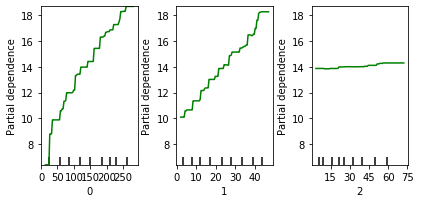

In [27]:
plot_partial_dependence(mod_lgbm, df_trainX, range(len(cfg_col_X))) 